# Training the model using image embeddings

### Reading the spectrogram features

In [39]:
import pandas as pd
all_data = pd.read_csv(r'spectrogram_features_google_vite.csv')

In [40]:
#display max column width
pd.set_option('display.max_colwidth', None)

In [41]:
all_data

,image_path,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_758,feature_759,feature_760,feature_761,feature_762,feature_763,feature_764,feature_765,feature_766,feature_767
0,spectrograms/4 July 2018 Dataset/3P66A03R2_spectrogram.png,-0.048340,0.055817,-0.145508,-0.373291,-0.008018,-0.236084,0.068909,0.140747,-0.217529,...,-0.162354,0.164551,-0.133057,-0.170166,-0.205322,0.122070,-0.059418,-0.201294,0.055756,-0.131348
1,spectrograms/4 July 2018 Dataset/1P68A01R1_spectrogram.png,0.034607,-0.034241,-0.101257,-0.314209,-0.255371,-0.125732,0.016068,-0.000095,-0.256104,...,0.003653,0.202759,0.092041,-0.255371,0.031555,0.203857,0.094727,-0.272217,0.088928,-0.055908
2,spectrograms/4 July 2018 Dataset/5P60A05R1_spectrogram.png,-0.086121,0.089172,-0.174683,-0.426758,-0.082092,-0.114990,-0.052063,0.198975,-0.243286,...,-0.085144,0.154419,-0.027039,-0.070984,-0.189209,0.252930,-0.048798,-0.265381,0.128418,-0.162598
3,spectrograms/4 July 2018 Dataset/3P65A03R3_spectrogram.png,-0.034821,0.034851,-0.234253,-0.427246,-0.048126,-0.329834,0.031830,0.111877,-0.276123,...,-0.143921,0.160767,-0.096436,-0.269531,-0.185791,0.252930,-0.139282,-0.265625,0.129761,-0.154175
4,spectrograms/4 July 2018 Dataset/1P62A01R2_spectrogram.png,0.058044,-0.131958,-0.123047,-0.252197,-0.213013,-0.140991,0.030991,-0.042145,-0.204224,...,-0.011017,0.183838,0.079102,-0.236328,-0.012367,0.303711,-0.006874,-0.223999,0.184082,-0.125366
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1749,spectrograms/1 December 2017 Dataset/6P56A06R02_spectrogram.png,-0.045807,-0.061523,-0.045197,-0.329102,-0.037079,-0.083801,-0.027954,0.187988,-0.169800,...,-0.062195,0.154175,0.066467,-0.085999,-0.137573,0.116211,0.149658,-0.290771,0.050995,-0.086914
1750,spectrograms/1 December 2017 Dataset/1P42A01R03_spectrogram.png,0.025467,-0.013214,-0.195801,-0.453125,-0.275391,-0.149902,-0.021835,0.052521,-0.262939,...,0.060883,0.209473,-0.049927,-0.178589,-0.123962,0.248047,-0.003431,-0.199829,0.122925,-0.065186
1751,spectrograms/1 December 2017 Dataset/6P40A06R03_spectrogram.png,-0.044037,-0.016708,-0.088562,-0.362061,-0.119751,-0.167114,-0.026672,0.211792,-0.144775,...,-0.124756,0.161621,0.080872,-0.367676,-0.092163,0.234619,0.042145,-0.232544,0.061737,-0.078857
1752,spectrograms/1 December 2017 Dataset/2P56A02R01_spectrogram.png,0.064026,-0.040649,-0.171021,-0.335693,-0.171387,-0.112244,-0.003649,0.106323,-0.143188,...,-0.133911,0.197388,-0.149780,-0.167725,-0.093750,0.029999,0.056335,-0.224609,0.089600,-0.127808


# Extracting the labels of the data

In [42]:
import pandas as pd
import re
import os

# Assuming 'df' is your pandas DataFrame
# For example:
# df = pd.DataFrame({'image_path': ['/path/to/1P24A01R2_spectrogram.png']})

# If already loaded:
df = all_data.copy()

# Function to extract the first number from the filename only
def extract_first_number_from_filename(path):
    filename = os.path.basename(path)  # Extracts just the filename
    match = re.search(r'(\d+)', filename)  # Looks for the first digit sequence
    if match:
        return int(match.group(1))  # Returns the number as an integer
    return None  # If no number is found

# Apply the function to the 'image_path' column and create the 'label' column
df['label'] = df['image_path'].apply(extract_first_number_from_filename)

# Display the DataFrame with the new 'label' column
print(df[['image_path', 'label']].head())

# To see the full DataFrame with the new column:
# print(df.head())


                                                   image_path  label
0  spectrograms/4 July 2018 Dataset/3P66A03R2_spectrogram.png      3
1  spectrograms/4 July 2018 Dataset/1P68A01R1_spectrogram.png      1
2  spectrograms/4 July 2018 Dataset/5P60A05R1_spectrogram.png      5
3  spectrograms/4 July 2018 Dataset/3P65A03R3_spectrogram.png      3
4  spectrograms/4 July 2018 Dataset/1P62A01R2_spectrogram.png      1


In [43]:
df

,image_path,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_759,feature_760,feature_761,feature_762,feature_763,feature_764,feature_765,feature_766,feature_767,label
0,spectrograms/4 July 2018 Dataset/3P66A03R2_spectrogram.png,-0.048340,0.055817,-0.145508,-0.373291,-0.008018,-0.236084,0.068909,0.140747,-0.217529,...,0.164551,-0.133057,-0.170166,-0.205322,0.122070,-0.059418,-0.201294,0.055756,-0.131348,3
1,spectrograms/4 July 2018 Dataset/1P68A01R1_spectrogram.png,0.034607,-0.034241,-0.101257,-0.314209,-0.255371,-0.125732,0.016068,-0.000095,-0.256104,...,0.202759,0.092041,-0.255371,0.031555,0.203857,0.094727,-0.272217,0.088928,-0.055908,1
2,spectrograms/4 July 2018 Dataset/5P60A05R1_spectrogram.png,-0.086121,0.089172,-0.174683,-0.426758,-0.082092,-0.114990,-0.052063,0.198975,-0.243286,...,0.154419,-0.027039,-0.070984,-0.189209,0.252930,-0.048798,-0.265381,0.128418,-0.162598,5
3,spectrograms/4 July 2018 Dataset/3P65A03R3_spectrogram.png,-0.034821,0.034851,-0.234253,-0.427246,-0.048126,-0.329834,0.031830,0.111877,-0.276123,...,0.160767,-0.096436,-0.269531,-0.185791,0.252930,-0.139282,-0.265625,0.129761,-0.154175,3
4,spectrograms/4 July 2018 Dataset/1P62A01R2_spectrogram.png,0.058044,-0.131958,-0.123047,-0.252197,-0.213013,-0.140991,0.030991,-0.042145,-0.204224,...,0.183838,0.079102,-0.236328,-0.012367,0.303711,-0.006874,-0.223999,0.184082,-0.125366,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1749,spectrograms/1 December 2017 Dataset/6P56A06R02_spectrogram.png,-0.045807,-0.061523,-0.045197,-0.329102,-0.037079,-0.083801,-0.027954,0.187988,-0.169800,...,0.154175,0.066467,-0.085999,-0.137573,0.116211,0.149658,-0.290771,0.050995,-0.086914,6
1750,spectrograms/1 December 2017 Dataset/1P42A01R03_spectrogram.png,0.025467,-0.013214,-0.195801,-0.453125,-0.275391,-0.149902,-0.021835,0.052521,-0.262939,...,0.209473,-0.049927,-0.178589,-0.123962,0.248047,-0.003431,-0.199829,0.122925,-0.065186,1
1751,spectrograms/1 December 2017 Dataset/6P40A06R03_spectrogram.png,-0.044037,-0.016708,-0.088562,-0.362061,-0.119751,-0.167114,-0.026672,0.211792,-0.144775,...,0.161621,0.080872,-0.367676,-0.092163,0.234619,0.042145,-0.232544,0.061737,-0.078857,6
1752,spectrograms/1 December 2017 Dataset/2P56A02R01_spectrogram.png,0.064026,-0.040649,-0.171021,-0.335693,-0.171387,-0.112244,-0.003649,0.106323,-0.143188,...,0.197388,-0.149780,-0.167725,-0.093750,0.029999,0.056335,-0.224609,0.089600,-0.127808,2


# Splitting the data in train,test and validation set

In [44]:
#from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
# Split the DataFrame into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns = ['image_path', 'label']), df['label'], test_size=0.2, random_state=42, stratify=df['label']
)

#split in validation set
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

## Performing PCA to reduce dimensionality from 1151 down to 100

In [45]:
#perform PCA on the training data
from sklearn.decomposition import PCA
pca = PCA(n_components=768)  # Reduce to 2 dimensions for visualization
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
X_val_pca = pca.transform(X_val)
# Convert the PCA results back to DataFrame for easier handling
X_train_pca = pd.DataFrame(X_train_pca, columns=[f'PC{i+1}' for i in range(X_train_pca.shape[1])])
X_test_pca = pd.DataFrame(X_test_pca, columns=[f'PC{i+1}' for i in range(X_test_pca.shape[1])])
X_val_pca = pd.DataFrame(X_val_pca, columns=[f'PC{i+1}' for i in range(X_val_pca.shape[1])])
# Display the PCA results

# Training

## Random Forest Classifier

In [46]:
#train the model
from sklearn.ensemble import RandomForestClassifier
# Create a Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs = 8)
# Fit the model on the training data
rf_classifier.fit(X_train_pca, y_train)

RandomForestClassifier(n_jobs=8, random_state=42)

### Calculating the accuracy

In [47]:
y_test.value_counts()

label
2    63
3    62
4    62
1    62
5    62
6    40
Name: count, dtype: int64

In [48]:
y_train.value_counts()

label
1    200
4    199
2    199
3    199
5    198
6    127
Name: count, dtype: int64

In [49]:
y_val.value_counts()

label
2    50
3    50
4    50
1    50
5    50
6    31
Name: count, dtype: int64

In [50]:
y_pred = rf_classifier.predict(X_test_pca)
from sklearn.metrics import classification_report, confusion_matrix
# Generate the classification report
print(classification_report(y_test, y_pred))
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)
#accuraccy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

              precision    recall  f1-score   support

           1       0.95      0.97      0.96        62
           2       0.65      0.76      0.70        63
           3       0.54      0.63      0.58        62
           4       0.55      0.58      0.56        62
           5       0.55      0.47      0.50        62
           6       0.96      0.55      0.70        40

    accuracy                           0.67       351
   macro avg       0.70      0.66      0.67       351
weighted avg       0.68      0.67      0.67       351

[[60  0  1  0  1  0]
 [ 0 48  5  6  3  1]
 [ 0 11 39  5  7  0]
 [ 1  8  9 36  8  0]
 [ 2  4 11 16 29  0]
 [ 0  3  7  3  5 22]]
Accuracy: 0.67


### Plotting the feature importance of the top 10 features

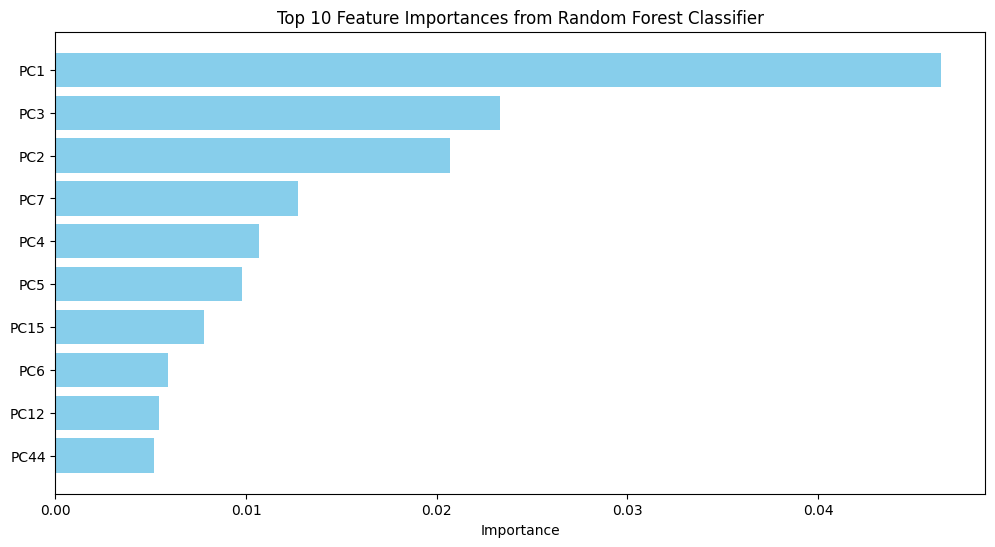

In [51]:
#plot the feature importances
import matplotlib.pyplot as plt
import numpy as np
# Get feature importances from the trained model
importances = rf_classifier.feature_importances_
# Create a DataFrame for feature importances
feature_importances = pd.DataFrame({
    'Feature': X_train_pca.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot the top 10 feature importances
top_n = 10
plt.figure(figsize=(12, 6))
plt.barh(feature_importances['Feature'][:top_n], feature_importances['Importance'][:top_n], color='skyblue')
plt.xlabel('Importance')
plt.title('Top 10 Feature Importances from Random Forest Classifier')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()

In [52]:
#multi-layer perceptron
from sklearn.neural_network import MLPClassifier
# Create a Multi-layer Perceptron Classifier and evaluate on validation set
mlp_classifier = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42, verbose = True)
mlp_classifier.fit(X_train_pca, y_train)
# Evaluate the model on the validation set
mlp_val_score = mlp_classifier.score(X_val_pca, y_val)
print(f'MLP Validation Score: {mlp_val_score:.4f}')

#test score
mlp_test_score = mlp_classifier.score(X_test_pca, y_test)
print(f'MLP Test Score: {mlp_test_score:.4f}')

Iteration 1, loss = 1.79264791
Iteration 2, loss = 1.73100044
Iteration 3, loss = 1.67376396
Iteration 4, loss = 1.61231198
Iteration 5, loss = 1.54377810
Iteration 6, loss = 1.46402836
Iteration 7, loss = 1.36921013
Iteration 8, loss = 1.25846391
Iteration 9, loss = 1.13214381
Iteration 10, loss = 0.99424324
Iteration 11, loss = 0.85661418
Iteration 12, loss = 0.72524201
Iteration 13, loss = 0.60587410
Iteration 14, loss = 0.50339419
Iteration 15, loss = 0.41669573
Iteration 16, loss = 0.34671557
Iteration 17, loss = 0.29152527
Iteration 18, loss = 0.24772665
Iteration 19, loss = 0.21182885
Iteration 20, loss = 0.18275578
Iteration 21, loss = 0.15938038
Iteration 22, loss = 0.13917158
Iteration 23, loss = 0.12193086
Iteration 24, loss = 0.10720617
Iteration 25, loss = 0.09418149
Iteration 26, loss = 0.08338698
Iteration 27, loss = 0.07323033
Iteration 28, loss = 0.06475168
Iteration 29, loss = 0.05691881
Iteration 30, loss = 0.05068099
Iteration 31, loss = 0.04507635
Iteration 32, los

              precision    recall  f1-score   support

           1       1.00      0.98      0.99        62
           2       0.92      0.97      0.95        63
           3       0.94      0.97      0.95        62
           4       0.74      0.77      0.76        62
           5       0.80      0.73      0.76        62
           6       0.97      0.95      0.96        40

    accuracy                           0.89       351
   macro avg       0.90      0.89      0.90       351
weighted avg       0.89      0.89      0.89       351



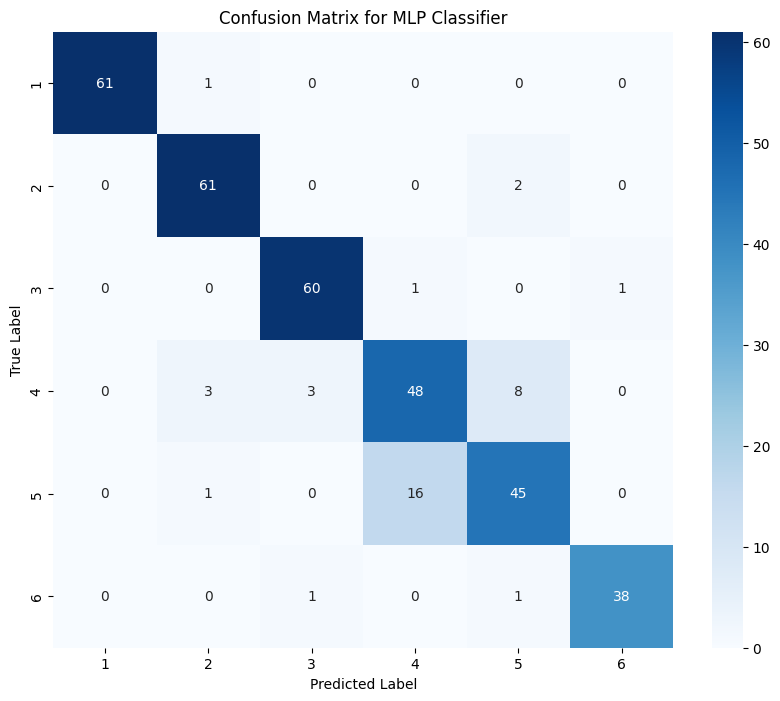

In [53]:
from sklearn.metrics import classification_report, confusion_matrix
# Generate predictions on the test set
y_pred_mlp = mlp_classifier.predict(X_test_pca)
# Generate the classification report
print(classification_report(y_test, y_pred_mlp))
# Generate the confusion matrix
conf_matrix_mlp = confusion_matrix(y_test, y_pred_mlp)
#make a confusion matrix plot
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_mlp, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for MLP Classifier')
plt.show()

In [54]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd # Assuming X_train_pca is a pandas DataFrame
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split



# Encode labels to start from 0 using LabelEncoder
le = LabelEncoder()
# Fit on all unique labels across all sets to ensure consistency
le.fit(np.unique(np.concatenate([y_train, y_val, y_test])))

# Transform all label sets
y_train_tensor = torch.tensor(le.transform(y_train), dtype=torch.long)
y_val_tensor = torch.tensor(le.transform(y_val), dtype=torch.long)
y_test_tensor = torch.tensor(le.transform(y_test), dtype=torch.long)

# Define number of classes
num_classes = len(le.classes_)

# Debug: Check label ranges
print("Unique values in y_train_tensor:", torch.unique(y_train_tensor))
print("Unique values in y_val_tensor:", torch.unique(y_val_tensor))
print("Unique values in y_test_tensor:", torch.unique(y_test_tensor))
print("num_classes:", num_classes)

# Assertions for label range (already present, good practice)
assert torch.all(y_train_tensor >= 0) and torch.all(y_train_tensor < num_classes), \
    f"y_train_tensor has out-of-range labels. Min: {y_train_tensor.min()}, Max: {y_train_tensor.max()}, Expected range [0, {num_classes-1}]"
assert torch.all(y_val_tensor >= 0) and torch.all(y_val_tensor < num_classes), \
    f"y_val_tensor has out-of-range labels. Min: {y_val_tensor.min()}, Max: {y_val_tensor.max()}, Expected range [0, {num_classes-1}]"
assert torch.all(y_test_tensor >= 0) and torch.all(y_test_tensor < num_classes), \
    f"y_test_tensor has out-of-range labels. Min: {y_test_tensor.min()}, Max: {y_test_tensor.max()}, Expected range [0, {num_classes-1}]"


# Convert PCA features to PyTorch tensors
# Ensure .values is used if X_pca is a pandas DataFrame
X_train_tensor = torch.tensor(X_train_pca.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_pca.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_pca.values, dtype=torch.float32)

# Check for NaNs/Infs in input tensors
print("X_train_tensor has NaNs:", torch.isnan(X_train_tensor).any())
print("X_train_tensor has Infs:", torch.isinf(X_train_tensor).any())
print("X_val_tensor has NaNs:", torch.isnan(X_val_tensor).any())
print("X_val_tensor has Infs:", torch.isinf(X_val_tensor).any())
print("X_test_tensor has NaNs:", torch.isnan(X_test_tensor).any())
print("X_test_tensor has Infs:", torch.isinf(X_test_tensor).any())


# Create DataLoader for training and validation sets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Define the neural network architecture
class SimpleNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x) # No activation here, as CrossEntropyLoss expects logits
        return x

# Initialize model, loss function, and optimizer
input_size = X_train_pca.shape[1]
model = SimpleNN(input_size, num_classes)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

# Training loop with early stopping
num_epochs = 5000
patience = 200
best_val_loss = float('inf')
early_stopping_counter = 0
best_model_path = 'best_model.pth' # Define path for saving best model

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)

    # Validation step
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

    val_loss /= len(val_loader.dataset)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}')

    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stopping_counter = 0
        torch.save(model.state_dict(), best_model_path)  # Save best model
    else:
        early_stopping_counter += 1

    if early_stopping_counter >= patience:
        print("Early stopping triggered")
        break

# Load best model for evaluation
print(f"Loading best model from {best_model_path}")
model.load_state_dict(torch.load(best_model_path))

# Evaluate on the test set
model.eval()
test_loss = 0.0
test_correct = 0
with torch.no_grad():
    test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=32)
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        test_correct += (predicted == labels).sum().item()

test_loss /= len(X_test_tensor)
test_accuracy = test_correct / len(X_test_tensor)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

# Save final model (optional, often you'd just use the best_model.pth for deployment)
final_model_path = 'final_model.pth'
torch.save(model.state_dict(), final_model_path)
print(f"Final model state saved to {final_model_path}")

# Load model for inference (example)
# loaded_model = SimpleNN(input_size, num_classes)
# loaded_model.load_state_dict(torch.load('final_model.pth'))
# loaded_model.to(device) # Don't forget to move it to device if you want to use it on GPU
# loaded_model.eval()

Unique values in y_train_tensor: tensor([0, 1, 2, 3, 4, 5])
Unique values in y_val_tensor: tensor([0, 1, 2, 3, 4, 5])
Unique values in y_test_tensor: tensor([0, 1, 2, 3, 4, 5])
num_classes: 6
X_train_tensor has NaNs: tensor(False)
X_train_tensor has Infs: tensor(False)
X_val_tensor has NaNs: tensor(False)
X_val_tensor has Infs: tensor(False)
X_test_tensor has NaNs: tensor(False)
X_test_tensor has Infs: tensor(False)
Using device: cuda
Epoch [1/5000], Loss: 1.1024, Val Loss: 0.5007
Epoch [2/5000], Loss: 0.3152, Val Loss: 0.3261
Epoch [3/5000], Loss: 0.1375, Val Loss: 0.3557
Epoch [4/5000], Loss: 0.0870, Val Loss: 0.3723
Epoch [5/5000], Loss: 0.0566, Val Loss: 0.3758
Epoch [6/5000], Loss: 0.0284, Val Loss: 0.4045
Epoch [7/5000], Loss: 0.1020, Val Loss: 0.4553
Epoch [8/5000], Loss: 0.0263, Val Loss: 0.4759
Epoch [9/5000], Loss: 0.0091, Val Loss: 0.4878
Epoch [10/5000], Loss: 0.0082, Val Loss: 0.5035
Epoch [11/5000], Loss: 0.0051, Val Loss: 0.5424
Epoch [12/5000], Loss: 0.0069, Val Loss: 0

C:\Users\Adnane\AppData\Local\Temp\ipykernel_25344\3050270799.py:139: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


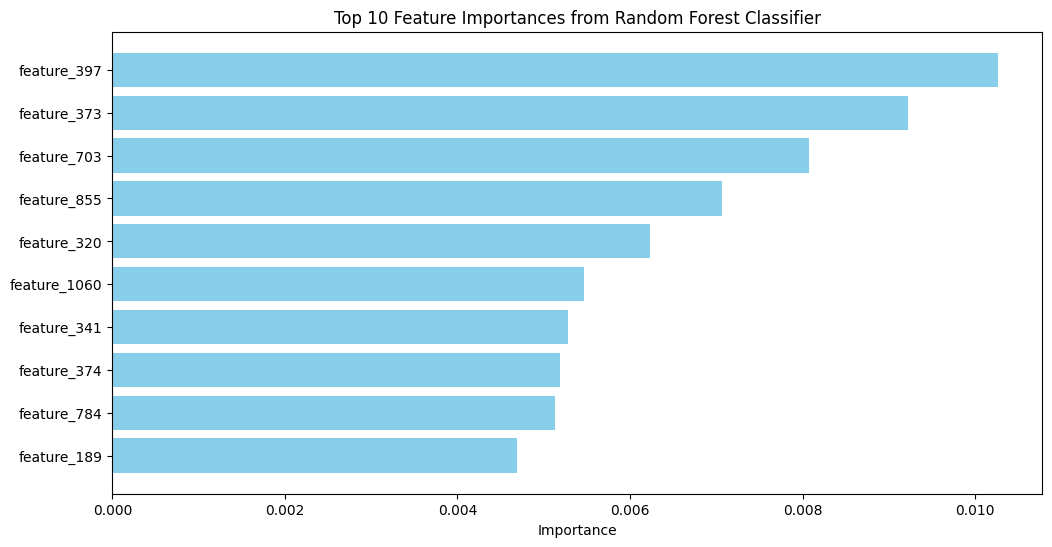

In [ ]:
#only keep the top 10 features
top_features = feature_importances['Feature'][:top_n].tolist()
# Filter the training and testing sets to keep only the top features
X_train_top = X_train[top_features]
X_test_top = X_test[top_features]
# Train the Random Forest Classifier on the top features
rf_classifier_top = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=8)
rf_classifier_top.fit(X_train_top, y_train)
# Evaluate the model on the test set
from sklearn.metrics import classification_report, confusion_matrix
# Make predictions on the test set
y_pred = rf_classifier_top.predict(X_test_top)
#print the accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy of Random Forest Classifier on test set: {accuracy:.2f}')

KeyError: "None of [Index(['PC1', 'PC3', 'PC2', 'PC7', 'PC4', 'PC5', 'PC15', 'PC6', 'PC12',\n       'PC44'],\n      dtype='object')] are in the [columns]"

In [32]:
#evaluate teh model on the test set
from sklearn.metrics import classification_report, accuracy_score
# Make predictions on the test set
y_pred = rf_classifier.predict(X_test_pca)
# Print the accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.8005698005698005
